In [13]:
from datetime import datetime
import os
import sys
from pathlib import Path

curr_dir = Path(os.path.split(os.getcwd())[0])

api_dir = str(curr_dir)
if api_dir not in sys.path:
    sys.path.insert(0, api_dir)
    

import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from src.model.classifier import Classifier
from src.datasets.ECG200 import ECG200
from src.model.explainer import explain_samples
from src.model.sample_explainers.gradient_shap import ShapGradientExplainer
from src.utils.dataset_creator import load_dataset

not_swan_default_modules = ["shap","coloredlogs"]
for name in not_swan_default_modules:
    if not name in sys.modules:
        !pip install --user name

ERROR: Can not perform a '--user' install. User site-packages are not visible in this virtualenv.
You should consider upgrading via the 'c:\users\holge\cernbox\mlframework\venv38\scripts\python.exe -m pip install --upgrade pip' command.


# Load dataset
dataset from https://www.timeseriesclassification.com/description.php?Dataset=ECG200

In [14]:
train, valid, test = load_dataset(creator=ECG200(),
                                  data_path=Path(api_dir) / "src/datasets/ECG200")

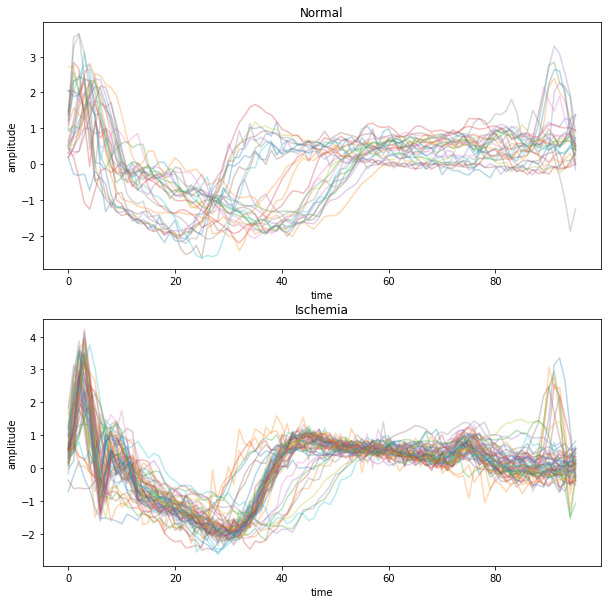

In [15]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].plot(train.X[train.y.argmax(axis=1) == 0][:,:,0].T, alpha=0.3)
ax[0].set_title("Normal")
ax[0].set_xlabel("time")
ax[0].set_ylabel("amplitude")
ax[1].plot(train.X[train.y.argmax(axis=1) == 1][:,:,0].T, alpha=0.3)
ax[1].set_title("Ischemia")
ax[1].set_xlabel("time")
ax[1].set_ylabel("amplitude")
plt.show()

# Classify heartbeats
To be able to classify the heartbeats a model needs created and to be fitted
## Create model

In [16]:
# Load hyperparameters
hp_file = open(Path(api_dir) / "src/model/default_hyperparameters.json")
hp_dict = json.load(hp_file)

In [17]:
# define and fit classifier
output_dir = Path(api_dir) / "src/output"/ datetime.now().strftime("%Y-%m-%dT%H.%M.%S")
clf = Classifier(input_shape=train.X.shape, output_directory=output_dir, **hp_dict)

## Fitting model
To fit the model to the training set the `.fit_classifier` method is used.

In [18]:
clf.fit_classifier(train, test)

Epoch 1/500
6/6 [==============================] - 3s 271ms/step - loss: 0.7003 - tp: 54.0000 - fp: 36.0000 - tn: 54.0000 - fn: 36.0000 - accuracy: 0.6000 - precision: 0.6000 - recall: 0.6000 - auc: 0.6757 - prc: 0.6339 - val_loss: 0.6881 - val_tp: 64.0000 - val_fp: 36.0000 - val_tn: 64.0000 - val_fn: 36.0000 - val_accuracy: 0.6400 - val_precision: 0.6400 - val_recall: 0.6400 - val_auc: 0.7546 - val_prc: 0.7334
Epoch 2/500
6/6 [==============================] - 0s 22ms/step - loss: 0.6915 - tp: 32.0000 - fp: 58.0000 - tn: 32.0000 - fn: 58.0000 - accuracy: 0.3556 - precision: 0.3556 - recall: 0.3556 - auc: 0.3683 - prc: 0.4393 - val_loss: 0.6938 - val_tp: 36.0000 - val_fp: 64.0000 - val_tn: 36.0000 - val_fn: 64.0000 - val_accuracy: 0.3600 - val_precision: 0.3600 - val_recall: 0.3600 - val_au

## Classification and evaluation
After training the network its possible to use the model on new data.
To apply the model on some data the `model.predict` method is used.
It is also possible to evaluate model performance using `model.evaluate`.

In [19]:
# make classification
y_pred = clf.model.predict(x=test.X)

In [20]:
# eval classifier
results = clf.model.evaluate(x=test.X, y=test.y, return_dict=True)
pd.DataFrame.from_dict(results, orient='index').T

4/4 [==============================] - 0s 22ms/step - loss: 1.3592 - tp: 84.0000 - fp: 16.0000 - tn: 84.0000 - fn: 16.0000 - accuracy: 0.8400 - precision: 0.8400 - recall: 0.8400 - auc: 0.9193 - prc: 0.9086


,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc
0,1.359184,84.0,16.0,84.0,16.0,0.84,0.84,0.84,0.9193,0.908559


# Explain classification
It might also be of interest, to get insight on what the network based its classification on.
Here we can use an explainer such as the SHAP gradient explainer.

In [21]:
is_correct_classification = (y_pred.argmax(axis=1) == test.y.argmax(axis=1))
ex_classification = explain_samples(explainer=ShapGradientExplainer(),
                                    model=clf.model,
                                    X_reference=train.X,
                                    X_to_explain=test.X[is_correct_classification, :, :])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


## Visualization of explanations
In order to present the sample explanation we can make a plot of the signal with a coloured overlay.
The overlay color is determined by the shap value.

In [22]:
def plot_importance(X_to_explain, y_pred, explanation):
    cmap = mpl.colors.LinearSegmentedColormap.from_list('shap', [mpl.cm.cool(0), (1, 1, 1, 1), mpl.cm.cool(256)],N=256)
    
    fig, ax = plt.subplots(figsize=(7,5))  
    ax.plot(X_to_explain[(y_pred.argmax(axis=1) == 0), :, :].mean(axis=0), linewidth=3, c="b")
    ax.plot(X_to_explain[(y_pred.argmax(axis=1) == 1), :, :].mean(axis=0), linewidth=3, c="r")
    
    extent = [0, len(X_to_explain[0]), ax.get_ylim()[0], ax.get_ylim()[1]]
    im1 = ax.imshow(explanation[0].mean(axis=0).T, cmap=cmap, aspect="auto", alpha=0.8, extent=extent)  
    cbar1 = fig.colorbar(im1, ax=ax)
    cbar1.set_label("SHAP values (relative)")

    ax.set_xlabel("samples")
    ax.set_xlabel("amplitude")
    ax.set_title("Explanations of Classifications")
    ax.legend(["Mean normal","Mean ischemia"])

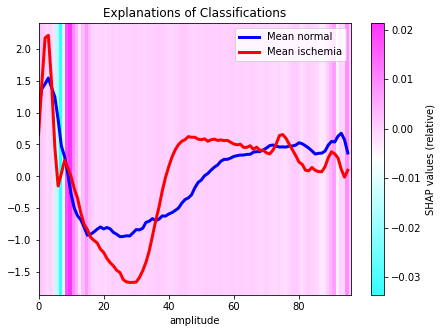

In [23]:
plot_importance(X_to_explain = test.X, y_pred = y_pred, explanation = ex_classification)
